# Chapter 09 - Panda Time Series and Date Handling

[Chapter 8-Time Series and Date Handling](08-Time_Series_and_Date_Handling.ipynb) provided a short introduction to Python's built-in datetime capabilities.  In this chapter we illustrate pandas time series and date handling.  



In [1]:
from datetime import date, time, datetime, timedelta
import polars as pl
from numpy.random import randn as rnd
from IPython.display import Image

## Creating and manipulating a fixed-frequency of dates and time spans

The pd.date_range() method generates a date column which is applied to a polars Series or DataFrame to provide datetime interval indexing.  We will see examples of its construction methods.

In [2]:
start_date = date(2016, 1, 1)
rng = pl.date_range(start_date, start_date + timedelta(days=30), interval='1d', eager=True)

In [3]:
rng

literal
date
2016-01-01
2016-01-02
2016-01-03
2016-01-04
2016-01-05
…
2016-01-27
2016-01-28
2016-01-29


Print the first 10 dates in the DateTimeIndex

In [4]:
rng.head(10)

literal
date
2016-01-01
2016-01-02
2016-01-03
2016-01-04
2016-01-05
2016-01-06
2016-01-07
2016-01-08
2016-01-09


Assemble a Series by using strings and integers for columns.  Map the year, month, and day value into a date timestamp using the pd.to_datetime() method.  Details for the pd.datetime() method are found <a href="https://docs.pola.rs/api/python/dev/reference/expressions/api/polars.datetime.html"> here</a>.

In [5]:
df = pl.DataFrame({'year': ['2014', '2015', '2016'],
                   'month': [1, 2, 3],
                   'day': [1,2,3,]})
df1 = df.with_columns(
    pl.date(pl.col('year'), pl.col('month'), pl.col('day'))
)
df1

year,month,day,date
str,i64,i64,date
"""2014""",1,1,2014-01-01
"""2015""",2,2,2015-02-02
"""2016""",3,3,2016-03-03


Construct the Series 'b_rng' containing only business days. Begin by supplying start and end date.  

In [6]:
start = datetime(2016, 1, 1)
end = datetime(2016, 12, 31)
rng = pl.date_range(start,end, eager=True)
# filter out weekends
b_rng = rng.filter((rng.dt.weekday() < 5))  # 0-4 are M-F, 5 & 6 are the weekend
# filtering out holidays is left as an exercise to the reader, but consider the holidays package
# b_rng = b_rng.filter((~b_rng.is_in([d for d in holidays.US(years=2026)])))

In [7]:
type(b_rng)  # if you get a `polars.expr.expr.Expr`, you have a lazy object, call b_rng.collect()

polars.series.series.Series

In [8]:
b_rng

literal
date
2016-01-04
2016-01-05
2016-01-06
2016-01-07
2016-01-11
…
2016-12-22
2016-12-26
2016-12-27


## Time Series Walk-Through

We can begin combining features covered in previous chapters to conduct a walk-through of a simple time series analysis.  

#### The Data

The data is the FHFA House Price Index (HPI) which is a broad measure of the movement of single-family house prices. It is a weighted, repeat-sales index, meaning that it measures average price changes in repeat sales or refinancing on the same properties. This information is obtained by reviewing repeat mortgage transactions on single-family properties whose mortgages have been purchased or securitized by Fannie Mae or Freddie Mac.  

Details about the data and how it is organized can be found <a href="https://catalog.data.gov/dataset/fhfa-house-price-indexes-hpis"> here </a>. This time series begins January 1991 and end August 2016.  Both the seasonally adjusted index 'index_sa' and the non-seaonally adjusted index 'index_nsa' set the index value at 100 for January 1991.  

#### The Inquiry

The three salient questions to answer are:

    1. Have U.S. aggregate home prices recovered their value since the Great Recession of 2008-2010? 
    2. Where are the highest and lowest values for 'traditional', 'purchase-only' homes in the U.S. in 2016? 
    3. How do the highest and lowest home values market segments compare to the aggregate U.S. home prices?
    
#### The Approach

The input .csv file located <a href="some_URL"> here </a>.  

The file is composed of two parts.  Part 1, rows 2 to 3081 are records for the aggregate market groups at the Census Division level.  The frequency interval is monthly.  

This portion of the file has 10 columns containing values for major market segments and the U.S. aggregate prices.  The price indicies are both seasonally adjusted and non-seasonally adjusted values.  The end-result DataFrame will be called 'df_us'.

Part 2, rows 3082 to 96,243 are more granular with a quarterly frequency interval. The major U.S. market segments are broken into smaller geographics areas with just the non-seasonaly adjusted home index value. Accordingly, the 10th column 'index_sa' contains no values at this location to the end of the file. The end-result DataFrame will be called 'df_states'.

Rather than arbitrarily reading a certain number of lines, we'll read the whole dataset in and subset the dataset by filtering (i.e., where clauses).


#### Part 1 of .csv File to Construct the 'df_us' DataFrame

Start with a test read of the entire .csv file.  The pl.read_csv method has the one required arguement, the input file name to create the DataFrame 'df_all'.

In [9]:
df_all = pl.read_csv('data/HPI_master.csv')

Inspect the first 5 rows to determine if the read_csv() method is giving the expected results.

In [10]:
df_all.head()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa
str,str,str,str,str,str,i64,i64,f64,f64
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,1,100.0,100.0
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,2,101.03,101.11
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,3,101.4,101.08
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,4,101.79,101.1
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,5,102.44,101.5


We need to combine the year and period fields into a datetime, but only when the frequency is 'monthly' (there's also the option of 'quarterly').  The .csv file in the cell above is read without any datetime parsing for the fields, 'yr' and 'period'.  We could post-process these fields to construct the appropriate date timestamp values.   

The nrows= argument value is set to 3080.  

In [36]:
df_monthly = df_all.filter(
    pl.col('frequency') == 'monthly'
)

In [37]:
df_us = df_monthly.with_columns(
    pl.datetime(pl.col('yr'), pl.col('period'), 1).alias('date')  # year, month, and day are all required, we'll default to the first
)

In [12]:
df_us.shape

(99325, 11)

Validate column names and their data types.  Confirm the date parser constructed the column 'date_idx' as a datetime object.

In [13]:
df_us.dtypes

[String,
 String,
 String,
 String,
 String,
 String,
 Int64,
 Int64,
 Float64,
 Float64,
 Datetime(time_unit='us', time_zone=None)]

Check for missing values.

In [38]:
df_us.null_count()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


Get the earlies and lastest date values in the 'df_us' DataFrame.

In [39]:
print(f'Earliest date is: {df_us['date'].min()}')
print(f'Latest date is: {df_us['date'].max()}')

Earliest date is: 1991-01-01 00:00:00
Latest date is: 2016-08-01 00:00:00


We see from the list of columns returned from the .info() attribute above we have several categorical columns.  We need to understand their levels.  Earlier, we saw the .describe() method used for numerical columns (in polars, also string columns).

In [40]:
df_us.describe()

statistic,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,str,f64,f64,f64,f64,str
"""count""","""3080""","""3080""","""3080""","""3080""","""3080""","""3080""",3080.0,3080.0,3080.0,3080.0,"""3080"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,null,null,null,2003.337662,6.448052,168.689734,167.717331,"""2003-10-16 13:42:51.428571"""
"""std""",null,null,null,null,null,null,7.41234,3.442172,48.318605,47.917088,null
"""min""","""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991.0,1.0,94.79,95.08,"""1991-01-01 00:00:00"""
"""25%""",null,null,null,null,null,null,1997.0,3.0,122.17,121.5,"""1997-06-01 00:00:00"""
"""50%""",null,null,null,null,null,null,2003.0,6.0,173.49,172.82,"""2003-11-01 00:00:00"""
"""75%""",null,null,null,null,null,null,2010.0,9.0,203.8,202.63,"""2010-03-01 00:00:00"""
"""max""","""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""West South Central Division""","""USA""",2016.0,12.0,311.34,305.33,"""2016-08-01 00:00:00"""


The 'place_name' column has 10 unique levels or values.  We can examine these values with the .unique() attribute.

In [41]:
df_us['place_name'].n_unique()

10

In [42]:
df_us['place_name'].unique()

place_name
str
"""Pacific Division"""
"""East South Central Division"""
"""South Atlantic Division"""
"""East North Central Division"""
"""New England Division"""
"""Middle Atlantic Division"""
"""West North Central Division"""
"""Mountain Division"""
"""West South Central Division"""


In [43]:
df_us_plot = df_us.filter(pl.col('place_name') == 'United States')
df_us_plot.height  # number of US records

308

Time series data lends itself well to plotting.  The bokeh package is used to plot the non-seasonal home price index for the entire U.S. using the 'df_us_plot' DataFrame created above

(This requires the `bokeh` package, which you can install with `pip install bokeh`.)

In [56]:
import bokeh
from bokeh.plotting import figure
from bokeh.palettes import Category10  # color scheme

# Display graphics in this notebook
bokeh.io.output_notebook()
# if you get `no module named bokeh`, run '!pip install bokeh` in a cell to install. Re-run this cell.

Loading BokehJS ...

Plot the monthly aggregate home index values for the U.S. using the earliest and latest dates from the 'df_us_plot' DataFrame.

In [44]:
df_us_plot.head()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,datetime[μs]
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""United States""","""USA""",1991,1,100.0,100.0,1991-01-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""United States""","""USA""",1991,2,100.47,100.53,1991-02-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""United States""","""USA""",1991,3,100.73,100.52,1991-03-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""United States""","""USA""",1991,4,100.75,100.38,1991-04-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""United States""","""USA""",1991,5,100.91,100.44,1991-05-01 00:00:00


In [46]:
p = figure(title="Monthly Aggregate Home Price Values in the U.S.",
           x_axis_label='Date', y_axis_label='Index NSA',
           x_axis_type='datetime', width=800, height=400)

p.line(df_us_plot['date'], df_us_plot['index_nsa'], color='firebrick', line_width=2)

# Display it
bokeh.io.show(p)

#### Answer to question 1
    Have U.S. aggregate home prices recovered their value since the Great Recession of 2008-2010?

During the Great Recession of 2008-2010, home prices across the U.S. declined dramatically.  The aggregate U.S. home price index has recovered all of the losses since that time and have continued to experience steady growth. 

Create the DataFrame 'df_us_3' to select the rows with the values indicated below.

In [54]:
# create a set with the place names we're interested in
place_names = {'West South Central Division', 'United States', 'Pacific Division'}
df_us_3 = df_us.filter(
    pl.col('place_name').is_in(place_names)
)

In [49]:
df_us_3.describe()

statistic,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,str,f64,f64,f64,f64,str
"""count""","""924""","""924""","""924""","""924""","""924""","""924""",924.0,924.0,924.0,924.0,"""924"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,"""0"""
"""mean""",null,null,null,null,null,null,2003.337662,6.448052,166.828009,165.901483,"""2003-10-16 13:42:51.428571"""
"""std""",null,null,null,null,null,null,7.41515,3.443477,50.449908,50.081537,null
"""min""","""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""Pacific Division""","""DV_PAC""",1991.0,1.0,95.27,95.08,"""1991-01-01 00:00:00"""
"""25%""",null,null,null,null,null,null,1997.0,3.0,117.23,116.8,"""1997-06-01 00:00:00"""
"""50%""",null,null,null,null,null,null,2003.0,6.0,170.55,170.85,"""2003-11-01 00:00:00"""
"""75%""",null,null,null,null,null,null,2010.0,9.0,201.02,199.71,"""2010-03-01 00:00:00"""
"""max""","""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""West South Central Division""","""USA""",2016.0,12.0,285.0,282.1,"""2016-08-01 00:00:00"""


Plot the 3 regions using the U.S. home price index for comparison.  Rather than specify a color value for color=, specifying a column label produces multiple plots based on the the levels.

In [147]:
p = figure(title='Monthly Home Price in West South Central and Pacific Division compared to U.S.',
           x_axis_label='Date', y_axis_label='Index NSA',
           x_axis_type='datetime', width=800, height=400)

# we'll draw a separate line for each place name
palette = Category10[10]
for i, place_name in enumerate(place_names):
    # i = current index (0, 1, 2, ...)
    temp_df = df_us_3.filter(pl.col('place_name') == place_name)
    # create a line for this data
    p.line(temp_df['date'], temp_df['index_nsa'], color=palette[i], legend_label=place_name, line_width=2)

# Display it
bokeh.io.show(p)

#### Part 2 of .csv File to Construct the 'df_states' DataFrame

Use to 'skiprows=' argument to begin reading at row 3082.  We use a tuple to specify the columns labels. 

Beginning with row 3082 the values for the field 'index_sa' are missing.  Begin the read at row 3082 until end of file.  And since the default is to key off column names, supply column labels with a<a href= "http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2002%20--%20Data%20Structures.ipynb#tuple"> tuple</a> of names.  The usecols= argument uses a tuple of integers to indicate which fields are to be read from the .csv file.  Header=None is to prevent the reader from building column names at row position nrows-1, which in our case contains data values.

In [61]:
df_states = df_all.filter(
    pl.col('frequency') == 'quarterly'
)

The columns 'yr' and 'period' are read as string values and need to be converted to datetime values.  The operation below creates the new column 'date_str' by:

    1. Concatenating 'yr' with 'Q' with 'period' to form a date string 
    2. The date string is passed to the pd.to_datetime function creating the dateime column 'date_idx'

    1. String concatenation operation to form YYYYq.

In [ ]:
# start_month_map = (
    pl.when(  # if
    pl.col('period') == 1  # first quarter
).then(1)  # January
.when(pl.col('period') == 2).then(4)  # 2nd -> April
.when(pl.col('period') == 3).then(7)  # 3rd -> July
.when(pl.col('period') == 4).then(10)  # 4th -> October
.otherwise(pl.lit(1))  # default to January (syntactically requried)
)

    2. Convert yr and period using the mapper created.

In [32]:
df_states = df_states.with_columns(
    pl.date(pl.col('yr'), start_month_map, pl.lit(1)).alias('date')
)

In [71]:
df_states.head()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,date
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1986,3,107.49,null,1986-07-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1986,4,94.95,null,1986-10-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1987,1,100.91,null,1987-01-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1987,2,100.76,null,1987-04-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1987,3,94.02,null,1987-07-01


Inspect the first 5 records in the 'df_states' DataFrame.

In [72]:
df_states.head()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,date
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1986,3,107.49,null,1986-07-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1986,4,94.95,null,1986-10-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1987,1,100.91,null,1987-01-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1987,2,100.76,null,1987-04-01
"""traditional""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1987,3,94.02,null,1987-07-01


Return the number of rows and columns in the DataFrame.

In [73]:
df_states.shape

(96245, 11)

In [74]:
df_states.height

96245

In [75]:
df_states.width

11

The following SAS Data Step reads the same .csv file using FIRSTOBS= to begin reading from the arbitary row position 3082.

````
    /********************************/
    /* c09_read()_csv_df_states.sas */
    /********************************/
    data df_states;
          infile 'C:\Data\HPI_master.csv' delimiter=',' missover dsd firstobs=3082; 
          informat hpi_type $12.
                   hpi_flavor $16.
                   frequency $9.
                   level $28.
                   place_name $33.
                   place_id $8.
                   yr $5.
                   period $6.
                   index_nsa 8.;
             input hpi_type $
                   hpi_flavor $
                   frequency $
                   level $
                   place_name $
                   place_id $
                   yr $
                   period $
                   index_nsa ;
````

Display the first 5 rows of the SAS data set df_states.  In the SAS code example below the 'yr' and 'period' variables are combined to create the SAS datetime variable 'date_idx'.

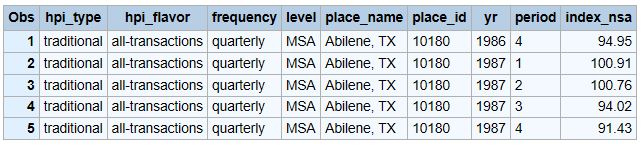

In [76]:
Image(filename='img/df_states_output.jpg')  

Inspect values for the categorical columns.

In [77]:
df_states.describe()

statistic,hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,str,f64,f64,f64,f64,str
"""count""","""96245""","""96245""","""96245""","""96245""","""96245""","""96245""",96245.0,96245.0,96243.0,29054.0,"""96245"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,2.0,67191.0,"""0"""
"""mean""",null,null,null,null,null,null,2000.210099,2.48921,150.843139,167.134666,"""2000-07-31 07:25:36.466000"""
"""std""",null,null,null,null,null,null,9.889633,1.117714,69.152998,56.212566,null
"""min""","""developmental""","""all-transactions""","""quarterly""","""MSA""","""Abilene, TX""","""10180""",1975.0,1.0,18.31,69.59,"""1975-01-01"""
"""25%""",null,null,null,null,null,null,1993.0,1.0,103.07,118.76,"""1993-07-01"""
"""50%""",null,null,null,null,null,null,2001.0,2.0,139.97,161.63,"""2001-04-01"""
"""75%""",null,null,null,null,null,null,2008.0,3.0,183.72,200.58,"""2008-10-01"""
"""max""","""traditional""","""purchase-only""","""quarterly""","""USA or Census Division""","""Yuma, AZ""","""WY""",2016.0,4.0,791.71,502.45,"""2016-04-01"""


## Returning Unique Levels of Categories

Get unique values for column 'level'

In [78]:
df_states['level'].unique()

level
str
"""USA or Census Division"""
"""State"""
"""MSA"""
"""Puerto Rico"""


PROC SQL used to obtain unique values from the variable 'level'.

````
    /******************************************************/
    /* c09_select_unique_level.sas                        */
    /******************************************************/
    56       proc sql;
    57          select unique level
    58          from df_states;
    59       quit;
````

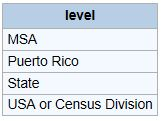

In [79]:
Image(filename='img/level_unique_values.jpg')  

Start by creating a list called 'targets' with the columns we want to look at.

In [82]:
targets = ['hpi_type', 'hpi_flavor', 'level']

If we had a long list of columns needing to determine unique values the approach above becomes tedious; an iterative approach is called for using the for statement shown below.

In [83]:
for item in targets[:4]:
   print(item, 'levels are:', df_states[item].unique())    

hpi_type levels are: shape: (4,)
Series: 'hpi_type' [str]
[
	"developmental"
	"non-metro"
	"distress-free"
	"traditional"
]
hpi_flavor levels are: shape: (3,)
Series: 'hpi_flavor' [str]
[
	"all-transactions"
	"expanded-data"
	"purchase-only"
]
level levels are: shape: (4,)
Series: 'level' [str]
[
	"USA or Census Division"
	"Puerto Rico"
	"State"
	"MSA"
]


Using the levels for the categorial columns displayed above, filter the 'df_state' DataFrame to match the 'df_us' Dataframe.

Create a boolean mask for the filtering criteria.

In [85]:
mask = (
    (df_states['hpi_type'] == 'traditional') & 
    (df_states['hpi_flavor'] == 'purchase-only') &
       (df_states['level'] == 'State')
)


Apply the mask.  Notice the 'df_states' DataFrame is updated in place with this assignment.  The original 'df_states' DataFrame had 96244 rows. 

In [86]:
df_states = df_states.filter(mask)

The .shape attribute returns the new row and column count for the 'df_states' DataFrame.

In [87]:
df_states.shape

(5202, 11)

#### Minimums and Maximums for Part 2, 'df_states' DataFrame

In [88]:
print(f'Max value for index_nsa: {df_states['index_nsa'].max()}')
print(f'Min value for index_nsa: {df_states['index_nsa'].min()}')

Max value for index_nsa: 503.11
Min value for index_nsa: 82.37


PROC SQL for finding min and max for the variable 'index_nsa'.

````
    /******************************************************/
    /* c09_min_max_index_nsa.sas                          */
    /******************************************************/
37      proc sql;
38         select max (index_nsa) as max_index_nsa,
39                min (index_nsa) as min_index_nsa
40         from df_states
41         where hpi_type ='traditional' and  hpi_flavor = 'purchase-only' and
42          level = 'State';
43      quit;
````

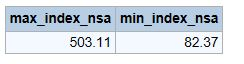

In [89]:
Image(filename='img/max_min_index_nsa.JPG')

#### Filter for  2016

For 2016, return the rows with the largest and smallest value for 'index_nsa'.  

In order to find the row with the lowest 'index_nsa' value, the example below uses a multi-step process:

1. Create a boolean mask filtering the rows with 'date' between January 1, 2016 and December 31, 2016. This will require using `pl.date` to convert our strings to dates..
3. Use the .min() attribute to return the row having the minimum 'index_nsa' value
4. Use the .max() attribute to return the row having the maximum 'index_nsa' value
    
Keep in mind that the 'df_states' DataFrame has already been filtered previously.

Create the boolean mask for the filtering criteria.

In [91]:
df_states.head()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,date
"""traditional""","""purchase-only""","""quarterly""","""State""","""Alaska""","""AK""",1991,1,100.0,100.0,1991-01-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Alaska""","""AK""",1991,2,100.72,100.16,1991-04-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Alaska""","""AK""",1991,3,101.58,100.94,1991-07-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Alaska""","""AK""",1991,4,102.48,102.26,1991-10-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Alaska""","""AK""",1992,1,102.36,102.3,1992-01-01


In [98]:
mask1 = (df_states['date'] >= pl.date(2016, 1, 1)) & (df_states['date'] <= pl.date(2016, 12, 31))

## Return a Row using a Minimum Value

Use the .idxmin() method to return the minimum 'index_nsa' value.

In [101]:
df_states.filter(mask1).filter(pl.col('index_nsa') == pl.col('index_nsa').min())

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,date
"""traditional""","""purchase-only""","""quarterly""","""State""","""Connecticut""","""CT""",2016,1,165.81,167.64,2016-01-01


## Return a Row using a Maximum Value

Use the .idxmax() attribute to return the row with the maximum 'index_nsa' value.

In [102]:
df_states.filter(mask1).filter(pl.col('index_nsa') == pl.col('index_nsa').max())

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,date
"""traditional""","""purchase-only""","""quarterly""","""State""","""District of Columbia""","""DC""",2016,2,501.35,502.45,2016-04-01


The .min and .max attribute return minimum and maximum respectively.  The .idxmin() attribute returns the entire row as a Series.  This enables the ability to use other column values, like 'place_name' or 'place_id' as further filtering and selection criteria.

The .min() and .max attributes return a scalar.

In [104]:
print(f"2016 minimum value for 'index_nsa': { df_states.filter(mask1)['index_nsa'].min()}")
print(f"2016 maximum value for 'index_nsa': { df_states.filter(mask1)['index_nsa'].max()}")

2016 minimum value for 'index_nsa': 165.81
2016 maximum value for 'index_nsa': 501.35


The SAS Data Step above used to the read .csv file does not create a SAS datetime variable.  This is illustrated below. 

The SAS example below uses a pair of PUT functions nested inside the YYQ function to create the SAS date variable 'date_idx'.  The PUT functions map the variables 'yr' and 'period' from character to numeric.  The YYQ function described <a href="http://support.sas.com/documentation/cdl/en/lrdict/64316/HTML/default/viewer.htm#a000199346.htm">here</a> returns a SAS datetime values from year and quarter values.

The Data Step below is continued from the SAS Data Step example above used to read the .csv file.

````
    /******************************************************/
    /* c09_min_max_index_nsa_for2016.sas                  */
    /******************************************************/
    12      date_idx=yyq(put(yr,8.),put(period,8.));
    13      format date_idx yyq10.;
    14      
    15      proc sql;
    16         select max (index_nsa) as max_index_nsa,
    17                min (index_nsa) as min_index_nsa
    18         from df_states
    19         where hpi_type ='traditional' and
    20               hpi_flavor = 'purchase-only' and
    21               level = 'State' and
    22               date_idx between '01Jan2016'd and '31Dec2016'd;
    23      quit;
````

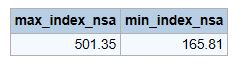

In [105]:
Image(filename='img/2016_min_max.jpg')

#### Answer to question #2

    2. Where are the highest and lowest values for 'traditional', 'purchase-only' homes in the U.S. in 2016? 
    
**Lowest home prices are in the state of Connecticut** and the **highest are in Washington, D.C.**  

Recall the 'df_states' DataFrame was filtered for column 'hpi_type' = 'traditional' **and** column 'hpi_flavor' = 'purchase-only' **and** level='state'.  This DataFrame was subsequently filtered to create the DataFrame 'df_2016' in which we searched for the lowest and highest home index values.

## Convert Time Series from one Frequency to Another

In order to answer the last question:
    How do the highest and lowest home values market segments compare to the aggregate U.S. home prices?
    
Information from the 'df_states' and 'df_us' DataFrame need to be combined.  The 'df_us' monthly values need to be downsampled to quarterly.  In other words, aggregated to a lower frequency.  In doing so, the frequency in both DataFrames become quarterly. 

In order to answer the 3rd question above, we need to conduct the following:
    1. Set the index for 'df_us' DataFrame to the column 'date_idx'
    2. Resample the 'df_us' DataFrame aggregating from monthly to quarterly using mean values
    3. Create a column in the 'df_us' labeled 'place_name' with the value "U.S. Aggregate".  
    4. Extract rows from 'df_states' DataFrame for lowest and highest home values using the column 'place_name' 
    5. Merge (concatenate) the resampled 'df_us' DataFrame with the high & low value rows from the extract operation
    6. Plot the resulting 'DataFrame'


Start by examining the quarterly date values from the 'df_states' DataFrame... 

In [106]:
 df_states.select('index_nsa', 'date').head()

index_nsa,date
f64,date
100.0,1991-01-01
100.72,1991-04-01
101.58,1991-07-01
102.48,1991-10-01
102.36,1992-01-01


...and compare with the monthly date values from the 'df_us' DataFrame.

In [107]:
df_us.select('index_nsa', 'date').head()

index_nsa,date
f64,datetime[μs]
100.0,1991-01-01 00:00:00
101.03,1991-02-01 00:00:00
101.4,1991-03-01 00:00:00
101.79,1991-04-01 00:00:00
102.44,1991-05-01 00:00:00


####    2. Resample the 'df_us' DataFrame aggregating from monthly to quarterly using mean values

pandas can perform resampling operations during frequency conversion (in this case, an aggregation of monthly values into quarterly values for the 'df_us' DataFrame). This is a common pattern in time series analysis.

The .resample() method is a time-based <a href=" ">needs a link to groupby</a> operation, followed by a reduction method on each of its groups.  Frequency conversion doc is found <a href="http://pandas.pydata.org/pandas-docs/stable/timeseries.html#frequency-conversion"> here</a>.  The .resample() method accepts frequency offset suffixes that are listed <a href="http://pandas.pydata.org/pandas-docs/stable/timeseries.html#anchored-offsets"> here</a>. 
 
In order to align the monthly date values found in the 'df_us' DataFrame, with the quarterly date values in the 'df_states' DataFrame, use the 'QS' date offset.  'QS' sets the date value frequency to quarterly with year ending in December.  The resulting DataFrame is called 'df_us_qtr'.

In [113]:
df_us.head()

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,datetime[μs]
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,1,100.0,100.0,1991-01-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,2,101.03,101.11,1991-02-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,3,101.4,101.08,1991-03-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,4,101.79,101.1,1991-04-01 00:00:00
"""traditional""","""purchase-only""","""monthly""","""USA or Census Division""","""East North Central Division""","""DV_ENC""",1991,5,102.44,101.5,1991-05-01 00:00:00


In [136]:
# df_us_qtr = df.resample('QS').mean()
df_us_qtr = df_us.sort('date').group_by_dynamic(
    'date', 
    every='3mo'
).agg([
    pl.col('index_nsa').mean().alias('index_nsa')
])
df_us_qtr

date,index_nsa
datetime[μs],f64
1991-01-01 00:00:00,100.391
1991-04-01 00:00:00,100.923333
1991-07-01 00:00:00,101.217667
1991-10-01 00:00:00,101.875333
1992-01-01 00:00:00,102.732333
…,…
2015-07-01 00:00:00,231.487333
2015-10-01 00:00:00,231.692667
2016-01-01 00:00:00,233.166


#### 3. Create a column in the 'df_us' labeled 'place_name' with the value "U.S. Aggregate". 

In [139]:
df_us_qtr = df_us_qtr.with_columns(
    pl.lit('US Aggregate').alias('place_name')
)

#### 4. Extract rows for the lowest and highest home values using the df_us_qtr['place_name'] column

Create a boolean mask using the logical OR operator ( | ).

In [131]:
mask = (
    (df_states['place_name'] == 'Connecticut') | 
    (df_states['place_name'] == 'District of Columbia')
)

Apply the mask using the <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2005%20--%20Understanding%20Indexes.ipynb#.loc-Indexer">.loc indexer</a> to create the 'hi_lo' DataFrame.

In [122]:
hi_lo = df_states.filter(mask)

#### 5. Merge (concatenate) the resampled 'df_us' DataFrame with the high & low value rows from the extract operation

Create a <a href="http://nbviewer.jupyter.org/github/RandyBetancourt/PythonForSASUsers/blob/master/Chapter%2002%20--%20Data%20Structures.ipynb#list">list</a> of DataFrames to be included in the concatenation operation.

In [132]:
df_us_qtr

date,index_nsa,place_name
datetime[μs],f64,str
1991-01-01 00:00:00,100.391,"""US Aggregate"""
1991-04-01 00:00:00,100.923333,"""US Aggregate"""
1991-07-01 00:00:00,101.217667,"""US Aggregate"""
1991-10-01 00:00:00,101.875333,"""US Aggregate"""
1992-01-01 00:00:00,102.732333,"""US Aggregate"""
…,…,…
2015-07-01 00:00:00,231.487333,"""US Aggregate"""
2015-10-01 00:00:00,231.692667,"""US Aggregate"""
2016-01-01 00:00:00,233.166,"""US Aggregate"""


In [137]:
# need to convert 'date' to date from datetime
df_us_qtr = df_us_qtr.with_columns(
    pl.col('date').dt.date().alias('date')
)

In [140]:
df_us_qtr.head()

date,index_nsa,place_name
date,f64,str
1991-01-01,100.391,"""US Aggregate"""
1991-04-01,100.923333,"""US Aggregate"""
1991-07-01,101.217667,"""US Aggregate"""
1991-10-01,101.875333,"""US Aggregate"""
1992-01-01,102.732333,"""US Aggregate"""


In [128]:
hi_lo

hpi_type,hpi_flavor,frequency,level,place_name,place_id,yr,period,index_nsa,index_sa,date
str,str,str,str,str,str,i64,i64,f64,f64,date
"""traditional""","""purchase-only""","""quarterly""","""State""","""Connecticut""","""CT""",1991,1,100.0,100.0,1991-01-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Connecticut""","""CT""",1991,2,97.81,98.03,1991-04-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Connecticut""","""CT""",1991,3,97.11,96.23,1991-07-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Connecticut""","""CT""",1991,4,96.53,95.84,1991-10-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""Connecticut""","""CT""",1992,1,97.3,97.38,1992-01-01
…,…,…,…,…,…,…,…,…,…,…
"""traditional""","""purchase-only""","""quarterly""","""State""","""District of Columbia""","""DC""",2015,2,466.75,467.47,2015-04-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""District of Columbia""","""DC""",2015,3,503.11,490.22,2015-07-01
"""traditional""","""purchase-only""","""quarterly""","""State""","""District of Columbia""","""DC""",2015,4,482.44,479.2,2015-10-01


Create the DataFrame 'plot_hi_low' concatenating values for the lowest home prices (Connecticut), with the highest ('District of Columbia') together with the U.S. aggregate.  This is accomplished using the <a href=" ">needs a link to concat</a> operation.

In [141]:
frames = [
    df_us_qtr,
    hi_lo.select('date', 'index_nsa', 'place_name')
]

In [143]:
plot_hi_low = pl.concat(frames)
plot_hi_low.head()

date,index_nsa,place_name
date,f64,str
1991-01-01,100.391,"""US Aggregate"""
1991-04-01,100.923333,"""US Aggregate"""
1991-07-01,101.217667,"""US Aggregate"""
1991-10-01,101.875333,"""US Aggregate"""
1992-01-01,102.732333,"""US Aggregate"""


## Plotting with bokeh  

In [148]:
p = figure(title='Comparison of lowest & highest home values with U.S. aggregate index value',
           x_axis_label='Date', y_axis_label='Index NSA',
           x_axis_type='datetime', width=800, height=400)

# we'll draw a separate line for each place name
palette = Category10[10]
for i, place_name in enumerate(plot_hi_low['place_name'].unique()):
    # i = current index (0, 1, 2, ...)
    temp_df = plot_hi_low.filter(pl.col('place_name') == place_name)
    # create a line for this data
    p.line(temp_df['date'], temp_df['index_nsa'], color=palette[i], line_width=2, legend_label=place_name)

# Display it
bokeh.io.show(p)

#### Answer to Question 3.
    3. How do the highest and lowest home values market segments compare to the aggregate U.S. home prices?

In the plot above, we see that the aggregate U.S. home price index regained its losses from the Great Recession (2008-2010) beginning around 2015.  Since then it has seen steady growth and has exceeded the peak from the pre-recession values.

In contrast, the home value index for Connecticut is just now recovering its value lost during the Great Recession.  However, it has not recovered its pre-recession value.

Since 2011, the aggregate U.S. home price index has been growing faster than that of Connecticut, but not even close to the growth rate for Washington, D.C.

Drop the values for 'District of Columbia' to compare the lowest home prices with the 'U.S. Aggregate' home price index.  Notice the automatic re-scaling of the Y-axis.

In [151]:
plt_lo_us = plot_hi_low.filter(pl.col('place_name') != 'District of Columbia')

In [152]:
p = figure(title='Comparison of lowest & highest home values with U.S. aggregate index value',
           x_axis_label='Date', y_axis_label='Index NSA',
           x_axis_type='datetime', width=800, height=400)

# we'll draw a separate line for each place name
palette = Category10[10]
for i, place_name in enumerate(plt_lo_us['place_name'].unique()):
    # i = current index (0, 1, 2, ...)
    temp_df = plt_lo_us.filter(pl.col('place_name') == place_name)
    # create a line for this data
    p.line(temp_df['date'], temp_df['index_nsa'], color=palette[i], line_width=2, legend_label=place_name)

# Display it
bokeh.io.show(p)

## Resources 

SAS 9.4 Language Reference: Concepts, 5th ed., <a href="http://support.sas.com/documentation/cdl/en/lrcon/68089/HTML/default/viewer.htm#n0q9ylcaccjgjrn19hvqnd9cte8p.htm"> Dates, Times, and Intervals

## Navigation

* [Next Chapter](09-Groupby.ipynb)
* [Return to Contents](00-Contents.ipynb)